In [39]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In our model, we introduce a forecasting agent who attempts to exploit a possible linear relationship between a stochastic signal $\theta_t$ and asset returns $r_t$. The agent observes the entire history of returns and $\theta$, but only uses the last $n$ observations to estimate a linear model via Least Square Learning. Agents have the following perceived law of motion for returns

$$
r_{t+1} = \beta \theta_t + \varepsilon_{t+1},
$$

and estimate the parameter $\beta$ by Recursive Ordinary Least square of the form 

$$
\beta_t = \frac{\sum^{t}_{s=0} r_{s+1} \theta_s}{\sum^{t}_{s=0}(\theta_s)^2}
$$

The Actual Law of Motion (ALM) for the asset price is 

$$
p_t = p^{e}_{t+1} + u_t,
$$

which implies that the forecasted price according to agents return expectations is

$$
p^e_{t+1} = (1 + \beta_t \theta_t) p^e_{t},
$$

where $p^e_{t}$ stresses that the current price is not available to agents when making their forecats, since it in an endogenous quantity determined in equilibrium. Consisten with their model though

$$
p^e_t = (1 + \beta_t \theta_{t+1}) p_{t-1},
$$
where the use of $\beta_t$ is justified by the belief that there is a constant homogenous $\beta$ and so it make sensa by using the 'smoothed' estimate obtained in place of $\beta_{t-1}$.
This implies an ALM for the current price

$$
p_t = (1 + \beta_t \theta_t)(1 + \beta_t \theta_{t-1}) p_{t-1} + u_t,
$$

and consistently for future return 

$$
r_{t+1} = \beta_{t+1} \theta_{t+1} + \beta_{t+1} \theta_t + (\beta_{t+1})^2 \theta_{t+1} \theta_t + \frac{u_t}{p_{t-1}}
$$


## 1) Fixed-point condition for BLE 

An equilibrium (BLE) requires that the **population** regression coefficient that agents would estimate from the ALM equals the $\beta$ they use in their PLM. Formally, let the population/regression slope implied by the ALM be

$$
b^*(\beta)\;=\;\frac{\operatorname{Cov}\big(r_{t+1},\theta_t\big)}{\operatorname{Var}(\theta_t)},
$$

where the covariance and variance are computed under the stationary law of motion induced by agents using $\beta$. A fixed point $\beta^\star$ satisfies

$$
\boxed{\;\beta^\star = b^*(\beta^\star)\; }.
$$

So compute $\operatorname{Cov}(r_{t+1},\theta_t)$ using your ALM-derived expression for $r_{t+1}$:

$$
r_{t+1} = \beta_{t+1}\theta_{t+1} + \beta_{t+1}\theta_t + \beta_{t+1}^2 \theta_{t+1}\theta_t + \frac{u_t}{p_{t-1}}.
$$

In a population/fixed-point calculation we replace $\beta_{t+1}$ by the candidate constant $\beta$ (agents believe $\beta$ is constant), and take expectations.

Thus under the fixed-$\beta$ ALM:

$$
r_{t+1}(\beta) = \beta\theta_{t+1} + \beta\theta_t + \beta^2 \theta_{t+1}\theta_t + \frac{u_t}{p_{t-1}}.
$$

Therefore

$$
\operatorname{Cov}\big(r_{t+1}(\beta),\theta_t\big)
= \beta\,\operatorname{Cov}(\theta_{t+1},\theta_t)
+ \beta\,\operatorname{Var}(\theta_t)
+ \beta^2\,\operatorname{Cov}(\theta_{t+1}\theta_t,\theta_t)
+ \operatorname{Cov}\!\Big(\frac{u_t}{p_{t-1}},\theta_t\Big).
$$

If $u_t$ is mean zero and independent of $\theta$, the last term is zero.

Hence the population slope is

$$
b^*(\beta)=
\frac{\beta\,\operatorname{Cov}(\theta_{t+1},\theta_t)
+ \beta\,\operatorname{Var}(\theta_t)
+ \beta^2\,\operatorname{Cov}(\theta_{t+1}\theta_t,\theta_t)}
{\operatorname{Var}(\theta_t)}.
$$

The fixed point equation $\beta = b^*(\beta)$ becomes

$$
\beta = \beta\Big(1 + \frac{\operatorname{Cov}(\theta_{t+1},\theta_t)}{\operatorname{Var}(\theta_t)}\Big)
+ \beta^2 \frac{\operatorname{Cov}(\theta_{t+1}\theta_t,\theta_t)}{\operatorname{Var}(\theta_t)}.
\tag{FP}
$$

---

## 2) IID $\theta_t$ (zero serial correlation) — multiplicity

Assume $\theta_t$ is iid with mean $0$ and variance $\sigma_\theta^2$. Then

* $\operatorname{Cov}(\theta_{t+1},\theta_t)=0$,
* for a *zero-mean symmetric* distribution (e.g. Gaussian) $\operatorname{Cov}(\theta_{t+1}\theta_t,\theta_t)=\mathbb{E}[\theta_{t+1}\theta_t^2] - \mathbb{E}[\theta_{t+1}]\mathbb{E}[\theta_t^2]=0$ because $\theta_{t+1}$ is independent of $\theta_t$ and has mean 0.

Plugging into (FP):

$$
\beta = \beta(1 + 0) + \beta^2 \cdot 0 \quad\Longrightarrow\quad \beta=\beta.
$$

This identity holds for **every** $\beta$. So every $\beta$ is a fixed point: the model has infinitely many BLEs. 


In [18]:
class Least_Square_Learning:
    def __init__(self, p0, pminus1, T=1000):
        self.p_tminus1 = p0
        self.p_tminus2 = pminus1
        self.r_tminus1 = (p0 - pminus1) / pminus1
        self.theta_tminus2 = np.random.normal(0, 1)
        self.theta_tminus1 = np.random.normal(0, 1)
        self.theta_t = np.random.normal(0, 1)
        #compute beta_t by least squares
        self.numerator_t = self.r_tminus1 * self.theta_tminus2
        self.denominator_t = self.theta_tminus2 ** 2
        self.beta_t = self.numerator_t / self.denominator_t 
        self.history_beta = [self.beta_t] #beta_t
        self.history_price = [p0] #p_t-2
        self.history_return = [self.r_tminus1] # r_t-1
        self.history_theta = [self.theta_t] #theta_t
        self.T = T

    def update(self):
        #first we compute p_t
        self.p_t = (1 + self.beta_t * self.theta_t) * (1 + self.beta_t * self.theta_tminus1) * self.p_tminus1 + np.random.normal(0, 1)
        #then we update the return r_t
        self.r_t = (self.p_t - self.p_tminus1) / self.p_tminus1
        #update theta
        self.theta_tplus1 = np.random.normal(0, 1)
        #update beta
        self.numerator_tplus1 = self.numerator_t + self.r_t * self.theta_tminus1
        self.denominator_tplus1 = self.denominator_t + self.theta_tminus1 ** 2
        self.beta_tplus1 = self.numerator_tplus1 / self.denominator_tplus1
        #update variables for next iteration
        self.p_tminus2 = self.p_tminus1
        self.p_tminus1 = self.p_t
        self.r_tminus1 = self.r_t
        self.theta_tminus2 = self.theta_tminus1
        self.theta_tminus1 = self.theta_t
        self.theta_t = self.theta_tplus1
        self.numerator_t = self.numerator_tplus1
        self.denominator_t = self.denominator_tplus1
        self.beta_t = self.beta_tplus1

        #store history
        self.history_beta.append(self.beta_t)
        self.history_price.append(self.p_t)
        self.history_return.append(self.r_t)
        self.history_theta.append(self.theta_t)

    def simulate(self):
        for t in range(self.T):
            self.update()
        return np.array(self.history_price), np.array(self.history_return), np.array(self.history_beta), np.array(self.history_theta)

In [44]:
#simulate for T periods
T = 10000
agent = Least_Square_Learning(p0=100, pminus1=100 + np.random.normal(0, 1), T=T)
p, r, b, theta = agent.simulate()

In [45]:
len(p), len(r), len(b), len(theta)

(10001, 10001, 10001, 10001)

In [46]:
#cpmpute correlation between r and theta shifted by two periods to have r_t and theta_t-1
corr = np.corrcoef(r[2:], theta[:-2])[0, 1]
#compute a "constant beta" as correlation times ratio of std deviations
constant_beta = corr * (np.std(r[2:]) / np.std(theta[:-2]))


Text(0.5, 0, 'Time')

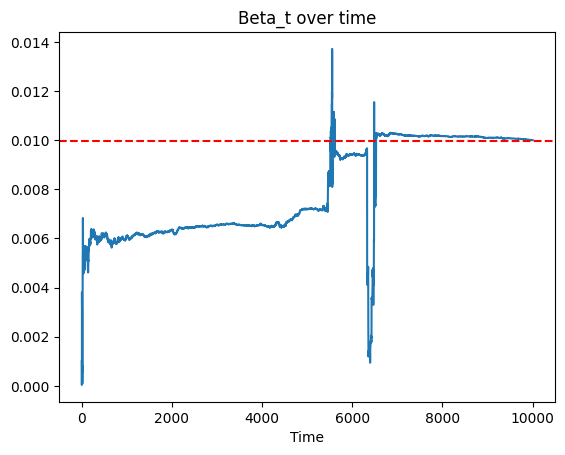

In [47]:
#plot the beta_t over time
plt.plot(b)
plt.title("Beta_t over time")
#add the correlation between r_t and theta_t-1 as horizontal line
plt.axhline(y=constant_beta, color='r', linestyle='--', label=f'Constant Beta: {constant_beta:.2f}')
plt.xlabel("Time")

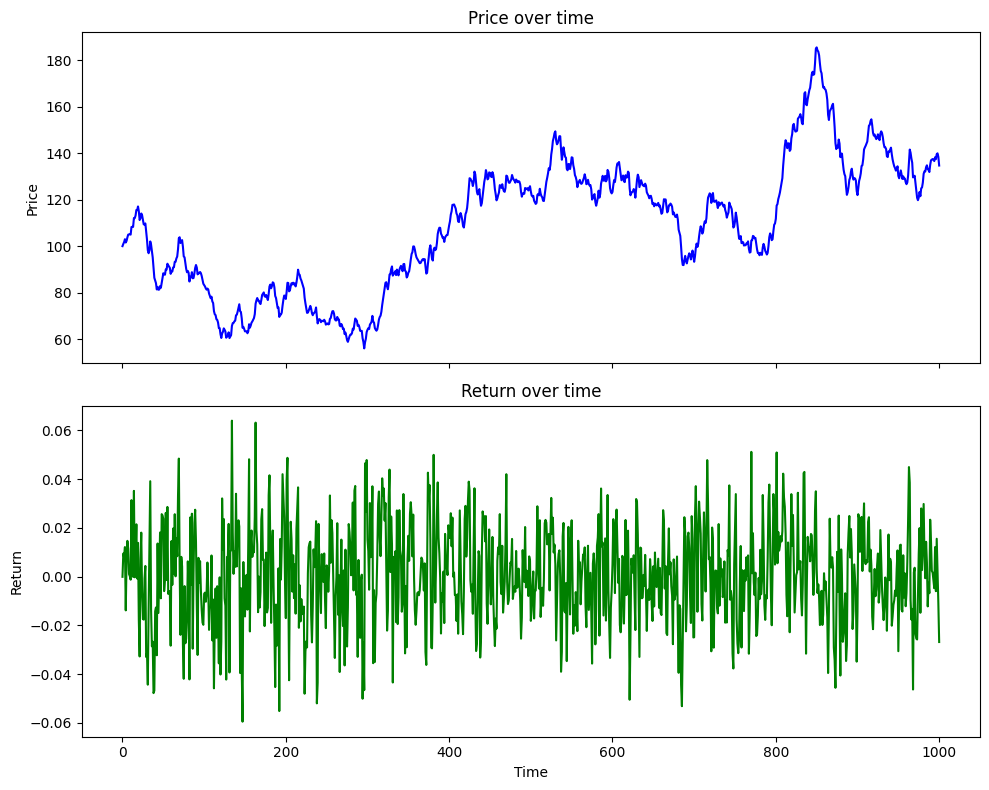

In [34]:
#plot returns and prices
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(p, color='blue')
axs[0].set_title("Price over time")
axs[0].set_ylabel("Price")
axs[1].plot(r, color='green')
axs[1].set_title("Return over time")
axs[1].set_ylabel("Return")
axs[1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [40]:
#check if we can predict returns from theta
X = theta[:-2].reshape(-1, 1)  # theta_t-1
y = r[2:]  # r_t

model = sm.OLS(y, sm.add_constant(X)).fit()

#results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     521.3
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           3.72e-93
Time:                        17:56:59   Log-Likelihood:                 2719.5
No. Observations:                 999   AIC:                            -5435.
Df Residuals:                     997   BIC:                            -5425.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.273      0.7